# פרויקט מודלים בייסיאנים #
## רועי בנימיני, עוז ניסנבוים, יובל לבל ##

In [2]:
!pip install pymc arviz

  Using cached arviz-0.23.1-py3-none-any.whl.metadata (9.1 kB)
   ---------------------------------------- 0.0/552.5 kB ? eta -:--:--
   ------------------ --------------------- 262.1/552.5 kB ? eta -:--:--
   ---------------------------------------- 552.5/552.5 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 10.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 46.1 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 46.1 MB/s eta 0:00:01
   ------------------------------- -------- 1.3/1.7 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 2.0 MB/s eta 0:00:00

   ------------- -------------------------- 3/9 [xarray-einstats]
   -------------------------- ------------- 6/9 [arviz]
   -------------------------- ------------- 6/9 [arviz]
   ----------

In [11]:
import pickle as pkl
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


# הגדרות תצוגה
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

## שאלה 1 ##

In [4]:
# טעינת הנתונים
df = pkl.load(open("C:\\Users\\RoyB\\Downloads\\part_1_group12.pkl", 'rb'))

# בחירת העיר הראשונה
first_city = df['city'].iloc[0]
print(f"העיר הראשונה: {first_city}")

# סינון: רק העיר הראשונה + רק נתוני אימון
df_city = df[(df['city'] == first_city) & (df['is_train'] == True)].copy()
print(f"מספר תצפיות לאימון: {len(df_city)}")

העיר הראשונה: Guelph
מספר תצפיות לאימון: 25


In [5]:
# משתנים מסבירים
num_vegans = df_city['num_vegans'].values.astype(float)
socio_economic = df_city['socio_econmic_profile'].values.astype(float)

# משתנה תלוי
y = df_city['tot_customers'].values.astype(float)

print(f"טווח num_vegans: {num_vegans.min():.0f} - {num_vegans.max():.0f}")
print(f"טווח socio_economic: {socio_economic.min():.0f} - {socio_economic.max():.0f}")
print(f"טווח tot_customers: {y.min():.0f} - {y.max():.0f}")

טווח num_vegans: 3 - 47
טווח socio_economic: 1 - 9
טווח tot_customers: 15 - 163


In [6]:
with pm.Model() as regression_model:
    
    # === הגדרת Priors (התפלגויות א-פריורי) ===
    # אנחנו משתמשים בפריורים "רחבים" (weakly informative)
    #בחרנו התפלגות נורמלית 
    
    b0 = pm.Normal('b0', mu=0, sigma=100)  # Intercept
    b1 = pm.Normal('b1', mu=0, sigma=100)  # מקדם ל-num_vegans
    b2 = pm.Normal('b2', mu=0, sigma=100)  # מקדם ל-socio_economic
    b3 = pm.Normal('b3', mu=0, sigma=100)  # מקדם לאינטראקציה
    
    # שונות השגיאה
    sigma = pm.HalfNormal('sigma', sigma=50)
    
    # === המודל הלינארי ===
    # Y = b0 + b1*num_vegans + b2*socio_economic + b3*num_vegans*socio_economic
    mu = b0 + b1*num_vegans + b2*socio_economic + b3*num_vegans*socio_economic
    
    # === Likelihood (פונקציית הנראות) ===
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

In [7]:
with regression_model:
    # דגימה באמצעות MCMC
    trace = pm.sample(2000, tune=1000, cores=1, random_seed=42)
    
print("הדגימה הסתיימה!")

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b0, b1, b2, b3, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 265 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


הדגימה הסתיימה!


In [8]:
# סיכום התוצאות
summary = az.summary(trace, var_names=['b0', 'b1', 'b2', 'b3', 'sigma'])
print(summary)

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b0      1.655  6.610 -10.930   14.105      0.221    0.165     908.0    1111.0   
b1      1.464  0.231   1.031    1.916      0.008    0.006     899.0    1174.0   
b2     12.171  1.081  10.194   14.300      0.036    0.026     921.0    1245.0   
b3      0.023  0.041  -0.050    0.103      0.001    0.001     926.0    1389.0   
sigma   8.265  1.451   5.693   11.046      0.053    0.040     606.0     310.0   

       r_hat  
b0       1.0  
b1       1.0  
b2       1.0  
b3       1.0  
sigma    1.0  


In [9]:
# שליפת ממוצעי ה-Posterior
b0_mean = trace.posterior['b0'].mean().item()
b1_mean = trace.posterior['b1'].mean().item()
b2_mean = trace.posterior['b2'].mean().item()
b3_mean = trace.posterior['b3'].mean().item()

# הצגת משוואת הרגרסיה
print("\n" + "="*70)
print("משוואת הרגרסיה לפי ממוצעי ה-Posteriors")
print("="*70)
print(f"\nY = {b0_mean:.4f} + {b1_mean:.4f}*num_vegans + {b2_mean:.4f}*socio_economic_profile + {b3_mean:.4f}*socio_economic_profile*num_vegan")
print(f"\nלעיר: {first_city}")
print("="*70)


משוואת הרגרסיה לפי ממוצעי ה-Posteriors

Y = 1.6554 + 1.4637*num_vegans + 12.1706*socio_economic_profile + 0.0233*socio_economic_profile*num_vegan

לעיר: Guelph


## שאלה 2 ##

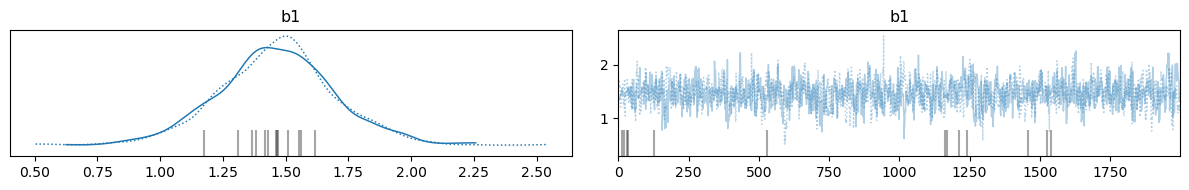

In [10]:
# בדיקת התכנסות ה-MCMC עבור המשתנה b1
az.plot_trace(trace, var_names=['b1'])
plt.tight_layout()
plt.show()

אכן ניתן לראות שבמשתנה שבחרנו יש  התכנסות. בגרף שמאל רואים שאת צורת הפעמון סביב 1.5 וכן בתרשים שמאל ניתן לראות רעש אקראי סביב הערך 1.5

## שאלה 3 ##

Sampling: [Y_obs]


Output()

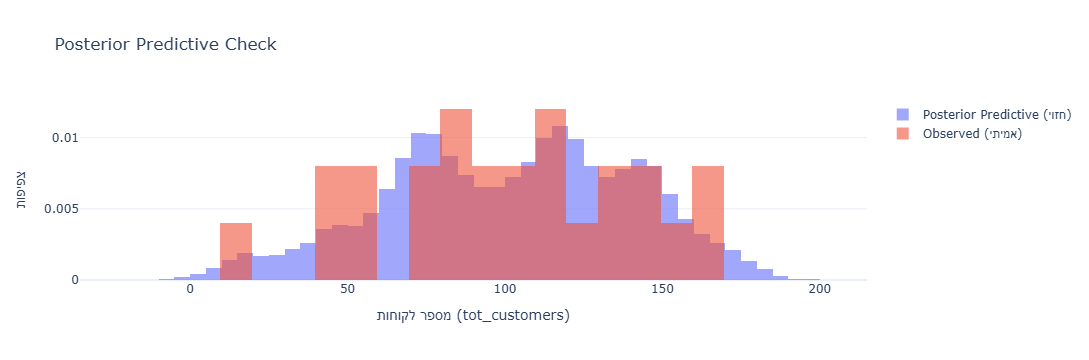

In [12]:

# יצירת דגימות מה-Posterior Predictive
with regression_model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

# שליפת הערכים החזויים
y_pred = ppc.posterior_predictive['Y_obs'].values.flatten()

# יצירת הגרף
fig = go.Figure()

# היסטוגרמה של הערכים החזויים
fig.add_trace(go.Histogram(
    x=y_pred, 
    name='Posterior Predictive (חזוי)',
    opacity=0.6,
    nbinsx=50,
    histnorm='probability density'
))

# היסטוגרמה של הנתונים האמיתיים
fig.add_trace(go.Histogram(
    x=y, 
    name='Observed (אמיתי)',
    opacity=0.6,
    nbinsx=15,
    histnorm='probability density'
))

fig.update_layout(
    title='Posterior Predictive Check',
    xaxis_title='מספר לקוחות (tot_customers)',
    yaxis_title='צפיפות',
    barmode='overlay',
    template='plotly_white'
)

fig.show()

ביצענו Posterior Predictive Check כדי לוודא שהמודל שבנינו מתאים לנתונים. דגמנו ערכים חדשים מהמודל והשווינו אותם לנתונים האמיתיים. כפי שרואים בגרף - שתי ההתפלגויות חופפות היטב, מה שמאשר שבחירת ה-Prior (התפלגות נורמלית רחבה) וה-Likelihood (התפלגות נורמלית) הייתה מתאימה לבעיה.

## שאלה 4 ##

In [13]:
# שלב 1: הכנת נתוני הטסט
df_test = df[(df['city'] == first_city) & (df['is_train'] == False)].copy()

X1_test = df_test['num_vegans'].values.astype(float)
X2_test = df_test['socio_econmic_profile'].values.astype(float)
y_test = df_test['tot_customers'].values.astype(float)

print(f"מספר תצפיות בטסט: {len(df_test)}")

# שלב 2: חיזוי לפי ממוצעי ה-Posterior
y_pred_test = b0_mean + b1_mean*X1_test + b2_mean*X2_test + b3_mean*X1_test*X2_test

# שלב 3: חישוב MSE
mse = np.mean((y_test - y_pred_test)**2)
print(f"MSE על הטסט: {mse:.4f}")

מספר תצפיות בטסט: 10
MSE על הטסט: 57.3859


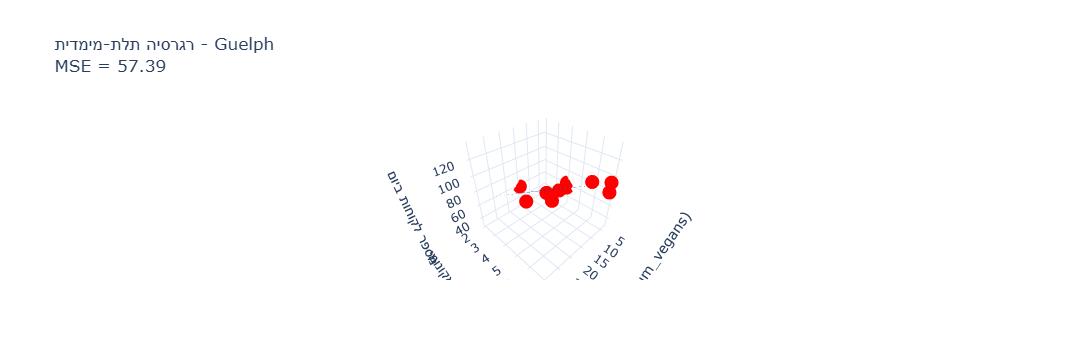

In [14]:
# שלב 4: גרף תלת-מימדי

# יצירת רשת לפני הרגרסיה
vegans_range = np.linspace(X1_test.min(), X1_test.max(), 30)
socio_range = np.linspace(X2_test.min(), X2_test.max(), 30)
vegans_grid, socio_grid = np.meshgrid(vegans_range, socio_range)

# חישוב פני הרגרסיה
z_surface = b0_mean + b1_mean*vegans_grid + b2_mean*socio_grid + b3_mean*vegans_grid*socio_grid

fig = go.Figure()

# פני הרגרסיה
fig.add_trace(go.Surface(
    x=vegans_grid, 
    y=socio_grid, 
    z=z_surface,
    name='משוואת הרגרסיה',
    opacity=0.7,
    colorscale='Blues',
    showscale=False
))

# נקודות אמיתיות
fig.add_trace(go.Scatter3d(
    x=X1_test, 
    y=X2_test, 
    z=y_test,
    mode='markers',
    marker=dict(size=8, color='red'),
    name='נתונים אמיתיים (Test)'
))

fig.update_layout(
    title=f'רגרסיה תלת-מימדית - {first_city}<br>MSE = {mse:.2f}',
    scene=dict(
        xaxis_title='מספר טבעונים (num_vegans)',
        yaxis_title='מצב סוציואקונומי',
        zaxis_title='מספר לקוחות ביום'
    ),
    template='plotly_white'
)

fig.show()